# Use feature engineering and Visual AI with high frequency data

**Author**: Abdul Khader Jilani

**Version Date**: 2023-02-22

## Summary

This example notebook shows how to generate advanced features other than traditional aggregated features used for high frequency data use cases. The notebook uses Gramian Angular Fields to generate features from high frequency time series datasets like sensor readings. These GAF features can be used with DataRobot Visual AI. This approach of feature engineering can be used as an augmentation to other feature engineering techniques like spectrograms.

<center><h3>GAF representation of two different signals</h3>

<img src='https://www.datarobot.com/wp-content/uploads/2021/11/unnamed-40.jpg'>

</center>

This notebook illustrates how to generate GAF interpretations of the signal. For performance comparison of this approach with other approaches, please refer to <a href='https://www.datarobot.com/blog/improving-signal-classification-using-visual-ai/'>this blogpost</a>.

For more information on how to run Visual AI projects with DataRobot's Python client, refer to <a href='https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/modeling/spec/visualai.html'>DataRobot's documentation</a>.


## Setup

### Import libraries

Access the following Python libraries using the links below:

- <a href='https://datarobot-public-api-client.readthedocs-hosted.com/en/v3.0.2/'>datarobot</a>
- <a href='https://pyts.readthedocs.io/en/stable/'> pyts </a>
- <a href='https://seaborn.pydata.org/'> seaborn </a>

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from PIL import Image
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
import urllib.request
import zipfile

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the Python client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [143]:
# Instantiate the DataRobot connection

DATAROBOT_API_TOKEN = "" # Get this from the Developer Tools page in the DataRobot UI
# Endpoint - This notebook uses the default endpoint for DataRobot Managed AI Cloud (US)
DATAROBOT_ENDPOINT = "https://app.datarobot.com/" # This should be the URL you use to access the DataRobot UI

client = dr.Client(
    token=DATAROBOT_API_TOKEN, 
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix='AIA-GC-HFI-32' #Optional but helps DataRobot improve this workflow
)

dr.client._global_client = client

### Import data

The [human activity recognition dataset](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) is a multiclass classification dataset with sensor data. Three sensors give nine time series signals as output. 

Replace the updated hyperlink to the dataset in the below cell if UCI has changed the URL for the dataset and the next cell errors out.

In [2]:
urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip", 
                           "./uci_dataset.zip")
with zipfile.ZipFile("./uci_dataset.zip","r") as zip_ref:
    zip_ref.extractall("./")
    
os.listdir('./UCI HAR Dataset/')

['.DS_Store',
 'test',
 'features.txt',
 'activity_labels.txt',
 'features_info.txt',
 'train',
 'README.txt']

## Data preparation

Prepare a multiclass image dataset for upload to DataRobot. For more information on creating image datasets for DataRobot please refer to <a href='https://www.datarobot.com/blog/getting-your-image-data-ready-for-visual-ai/'>DataRobot's blogpost</a>.

In [3]:
files = os.listdir('./UCI HAR Dataset/train/Inertial Signals/')
files.sort()
files

['body_acc_x_train.txt',
 'body_acc_y_train.txt',
 'body_acc_z_train.txt',
 'body_gyro_x_train.txt',
 'body_gyro_y_train.txt',
 'body_gyro_z_train.txt',
 'total_acc_x_train.txt',
 'total_acc_y_train.txt',
 'total_acc_z_train.txt']

In [4]:
y = pd.read_csv('./UCI HAR Dataset/train/y_train.txt', header=None, delim_whitespace=True).values
y.shape

(7352, 1)

Each text file collects high frequency readings from different mobile sensors like accelerometer and gyroscope.

In [5]:
acc_x = pd.read_csv('./UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt', header=None, delim_whitespace=True).values
acc_y = pd.read_csv('./UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt', header=None, delim_whitespace=True).values
acc_z = pd.read_csv('./UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt', header=None, delim_whitespace=True).values

acc_x.shape,acc_y.shape,acc_z.shape

((7352, 128), (7352, 128), (7352, 128))

In [6]:
gyro_x = pd.read_csv('./UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt', header=None, delim_whitespace=True).values
gyro_y = pd.read_csv('./UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt', header=None, delim_whitespace=True).values
gyro_z = pd.read_csv('./UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt', header=None, delim_whitespace=True).values

gyro_x.shape,gyro_y.shape,gyro_z.shape

((7352, 128), (7352, 128), (7352, 128))

In [8]:
total_x = pd.read_csv('./UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt', header=None, delim_whitespace=True).values
total_y = pd.read_csv('./UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt', header=None, delim_whitespace=True).values
total_z = pd.read_csv('./UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt', header=None, delim_whitespace=True).values

total_x.shape,total_y.shape,total_z.shape

((7352, 128), (7352, 128), (7352, 128))

### Generate images for high frequency mobile sensor readings

This notebook uses images based on the <a href='https://pyts.readthedocs.io/en/stable/auto_examples/image/plot_single_gaf.html#:~:text=A%20Gramian%20angular%20field%20is,image.'> gramarian angular field</a> to generate image features from signal data. This is similar to generating spectrograms for signal processing. There are nine signals from three sensors, and you will stack them into a single image as a 3x3 grid.

In [9]:
!mkdir 'images'

In [ ]:
gaf = GramianAngularField()
filenames = []
for i in tqdm(range(len(y))):
    img_acc_x = gaf.fit_transform(acc_x[i].reshape((-1,128)))[0]
    img_acc_y = gaf.fit_transform(acc_y[i].reshape((-1,128)))[0]
    img_acc_z = gaf.fit_transform(acc_z[i].reshape((-1,128)))[0]
    
    img_gyro_x = gaf.fit_transform(gyro_x[i].reshape((-1,128)))[0]
    img_gyro_y = gaf.fit_transform(gyro_y[i].reshape((-1,128)))[0]
    img_gyro_z = gaf.fit_transform(gyro_z[i].reshape((-1,128)))[0]
    
    img_total_x = gaf.fit_transform(total_x[i].reshape((-1,128)))[0]
    img_total_y = gaf.fit_transform(total_y[i].reshape((-1,128)))[0]
    img_total_z = gaf.fit_transform(total_z[i].reshape((-1,128)))[0]
    
    img_acc = np.concatenate((img_acc_x,img_acc_y,img_acc_z), axis=1)
    img_gyro = np.concatenate((img_gyro_x,img_gyro_y,img_gyro_z), axis=1)
    img_total = np.concatenate((img_total_x,img_total_y,img_total_z), axis=1)
    img = np.concatenate((img_acc, img_gyro, img_total), axis=0)
    img = ((img + 1) / (2) ) * (255 - 0) + 0
    
    image = Image.fromarray(img)
    image = image.convert('RGB')
    image = image.resize((224,224))
    image.save('./images/'+str(i)+'.png')
    filenames.append('./images/'+str(i)+'.png')
print(len(filenames))

In [11]:
dict_activity = {1:'WALKING',
2:'WALKING_UPSTAIRS',
3:'WALKING_DOWNSTAIRS',
4:'SITTING',
5:'STANDING',
6:'LAYING'}

def get_label(val):
    return dict_activity.get(val)

In [12]:
df_subject = pd.read_csv('./UCI HAR Dataset/train/subject_train.txt', header=None, delim_whitespace=True)
df_subject.columns = ['subject_id']
df_dr = pd.read_csv('./UCI HAR Dataset/train/y_train.txt', header=None, delim_whitespace=True)
df_dr.columns = ['target']
df_dr['image'] = filenames
df_dr['subject_id'] = df_subject['subject_id']
df_dr['target_str'] =  df_dr.target.apply(get_label)
df_dr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   target      7352 non-null   int64 
 1   image       7352 non-null   object
 2   subject_id  7352 non-null   int64 
 3   target_str  7352 non-null   object
dtypes: int64(2), object(2)
memory usage: 229.9+ KB


In [15]:
df_dr[['image', 'subject_id', 'target_str']].head()

,image,subject_id,target_str
0,./images/0.png,1,STANDING
1,./images/1.png,1,STANDING
2,./images/2.png,1,STANDING
3,./images/3.png,1,STANDING
4,./images/4.png,1,STANDING


The following cell's output provides an example of how GAF representations of the sensor readings appear:

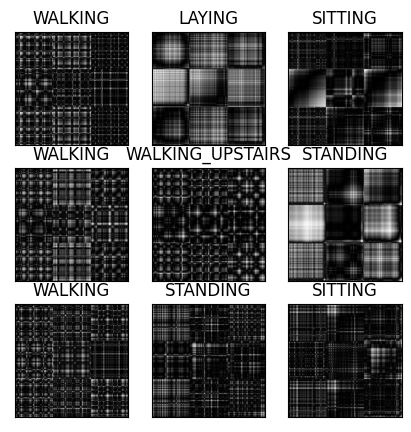

In [124]:
w = 5
h = 5
fig = plt.figure(figsize=(5, 5))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    row = df_dr.sample(1).iloc[0]
    img = Image.open(row['image'])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(row['target_str'])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [121]:
df_dr[['image', 'subject_id', 'target_str']].to_csv('./df_har.csv',index=False)

In [23]:
zf = zipfile.ZipFile('./dr_high_freq_multiclass.zip', 'w')
zf.write('./df_har.csv')
for dirname, subdirs, files in tqdm(os.walk("./images/")):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()

1it [00:18, 18.03s/it]


## Modeling

### Create a multiclass project

Create a project and build models to predict the classification target.

In [19]:
import datarobot as dr
dr.__version__

'3.0.2'

Note that image datasets are larger files and commonly take longer than tabular datasets to upload. Speed of upload may depend on multiple factors. 

In [44]:
# partition_method = dr.GroupTVH(partition_key_cols=['subject_id'], validation_pct=20, holdout_pct=20)
partition_method = dr.GroupCV(partition_key_cols=['subject_id'], reps=5, holdout_pct=20)

datarobot.helpers.partitioning_methods.GroupCV

In [42]:
project = dr.Project.create('./dr_high_freq_multiclass.zip', 
                            project_name='High Frequency MultiClass using GAF Features')

### Start Autopilot

In [43]:
project.analyze_and_model(target='target_str',
                          mode=dr.AUTOPILOT_MODE.FULL_AUTO,
                          partitioning_method=partition_method,
                          worker_count = -1)

Project(High Frequency MultiClass using GAF Features)

### Get the top-performing model

In [45]:
recommended_model = project.recommended_model()
recommended_model

Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)')

In [48]:
project.unlock_holdout()
recommended_model.get_all_confusion_charts()

[ConfusionChart(crossValidation),
 ConfusionChart(holdout),
 ConfusionChart(validation)]

### Visualize model performance

In [77]:
conf_chart = recommended_model.get_confusion_chart(dr.enums.CHART_DATA_SOURCE.HOLDOUT, 
                                                   fallback_to_parent_insights=True)
perf_df = pd.DataFrame(conf_chart.class_metrics)[['class_name','actual_count','predicted_count',
                                                  'f1','recall','precision']]
perf_df

,class_name,actual_count,predicted_count,f1,recall,precision
0,LAYING,272,295,0.744268,0.775735,0.715254
1,SITTING,258,214,0.584746,0.534884,0.644860
2,STANDING,266,280,0.688645,0.706767,0.671429
3,WALKING,238,229,0.950749,0.932773,0.969432
4,WALKING_DOWNSTAIRS,203,222,0.898824,0.940887,0.860360
5,WALKING_UPSTAIRS,222,219,0.934240,0.927928,0.940639


Text(0.5, 1.0, '**Holdout Confusion Matrix')

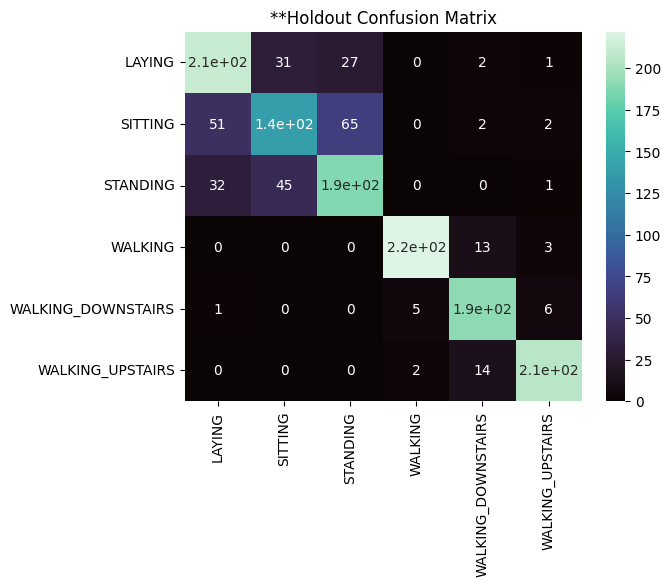

In [81]:
import seaborn as sns
hm = pd.DataFrame(conf_chart.confusion_matrix)
hm.columns = conf_chart.classes
hm.index = conf_chart.classes
sns.heatmap(hm, annot=True, cmap='mako')
plt.title('**Holdout Confusion Matrix')

### Activation Maps

Create activation maps with a trained data sample.

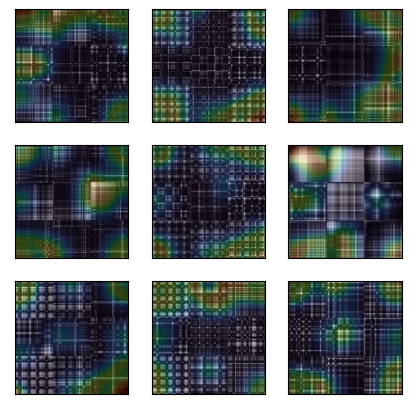

In [142]:
import io
from datarobot.models.visualai import ImageActivationMap

w = 5
h = 5
fig = plt.figure(figsize=(5, 5))
columns = 3
rows = 3
activation_maps = ImageActivationMap.list(project.id, recommended_model.id, 'image')[:rows*columns+1]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    activation_map = activation_maps[i]
    bio = io.BytesIO(activation_map.overlay_image.image_bytes)
    img = Image.open(bio)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

## Prepare test data for predictions

In [82]:
files_test = os.listdir('./UCI HAR Dataset/test/Inertial Signals/')
files_test.sort()
files_test

['body_acc_x_test.txt',
 'body_acc_y_test.txt',
 'body_acc_z_test.txt',
 'body_gyro_x_test.txt',
 'body_gyro_y_test.txt',
 'body_gyro_z_test.txt',
 'total_acc_x_test.txt',
 'total_acc_y_test.txt',
 'total_acc_z_test.txt']

In [89]:
acc_x_test = pd.read_csv('./UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt', header=None, delim_whitespace=True).values
acc_y_test = pd.read_csv('./UCI HAR Dataset/test/Inertial Signals/body_acc_y_test.txt', header=None, delim_whitespace=True).values
acc_z_test = pd.read_csv('./UCI HAR Dataset/test/Inertial Signals/body_acc_z_test.txt', header=None, delim_whitespace=True).values

acc_x_test.shape,acc_y_test.shape,acc_z_test.shape

((2947, 128), (2947, 128), (2947, 128))

In [86]:
gyro_x_test = pd.read_csv('./UCI HAR Dataset/test/Inertial Signals/body_gyro_x_test.txt', header=None, delim_whitespace=True).values
gyro_y_test = pd.read_csv('./UCI HAR Dataset/test/Inertial Signals/body_gyro_y_test.txt', header=None, delim_whitespace=True).values
gyro_z_test = pd.read_csv('./UCI HAR Dataset/test/Inertial Signals/body_gyro_z_test.txt', header=None, delim_whitespace=True).values

gyro_x_test.shape,gyro_y_test.shape,gyro_z_test.shape

((2947, 128), (2947, 128), (2947, 128))

In [88]:
total_x_test = pd.read_csv('./UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt', header=None, delim_whitespace=True).values
total_y_test = pd.read_csv('./UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt', header=None, delim_whitespace=True).values
total_z_test = pd.read_csv('./UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt', header=None, delim_whitespace=True).values

total_x_test.shape,total_y_test.shape,total_z_test.shape

((2947, 128), (2947, 128), (2947, 128))

In [92]:
y_test = pd.read_csv('./UCI HAR Dataset/test/y_test.txt', header=None, delim_whitespace=True).values
y_test.shape

(2947, 1)

In [96]:
!mkdir './images_test'

In [ ]:
gaf = GramianAngularField()
filenames = []
for i in tqdm(range(len(y_test))):
    img_acc_x = gaf.fit_transform(acc_x_test[i].reshape((-1,128)))[0]
    img_acc_y = gaf.fit_transform(acc_y_test[i].reshape((-1,128)))[0]
    img_acc_z = gaf.fit_transform(acc_z_test[i].reshape((-1,128)))[0]
    
    img_gyro_x = gaf.fit_transform(gyro_x_test[i].reshape((-1,128)))[0]
    img_gyro_y = gaf.fit_transform(gyro_y_test[i].reshape((-1,128)))[0]
    img_gyro_z = gaf.fit_transform(gyro_z_test[i].reshape((-1,128)))[0]
    
    img_total_x = gaf.fit_transform(total_x_test[i].reshape((-1,128)))[0]
    img_total_y = gaf.fit_transform(total_y_test[i].reshape((-1,128)))[0]
    img_total_z = gaf.fit_transform(total_z_test[i].reshape((-1,128)))[0]
    
    img_acc = np.concatenate((img_acc_x,img_acc_y,img_acc_z), axis=1)
    img_gyro = np.concatenate((img_gyro_x,img_gyro_y,img_gyro_z), axis=1)
    img_total = np.concatenate((img_total_x,img_total_y,img_total_z), axis=1)
    img = np.concatenate((img_acc, img_gyro, img_total), axis=0)
    img = ((img + 1) / (2) ) * (255 - 0) + 0
    
    image = Image.fromarray(img)
    image = image.convert('RGB')
    image = image.resize((224,224))
    image.save('./images_test/'+str(i)+'.png')
    filenames.append('./images_test/'+str(i)+'.png')
print(len(filenames))

In [99]:
df_subject = pd.read_csv('./UCI HAR Dataset/test/subject_test.txt', header=None, delim_whitespace=True)
df_subject.columns = ['subject_id']
df_dr = pd.read_csv('./UCI HAR Dataset/test/y_test.txt', header=None, delim_whitespace=True)
df_dr.columns = ['target']
df_dr['image'] = filenames
df_dr['subject_id'] = df_subject['subject_id']
df_dr['target_str'] =  df_dr.target.apply(get_label)
df_dr[['image', 'subject_id', 'target_str']].to_csv('./df_har_test.csv',index=False)
df_dr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   target      2947 non-null   int64 
 1   image       2947 non-null   object
 2   subject_id  2947 non-null   int64 
 3   target_str  2947 non-null   object
dtypes: int64(2), object(2)
memory usage: 92.2+ KB


In [ ]:
zf = zipfile.ZipFile('./dr_high_freq_multiclass_test.zip', 'w')
zf.write('./df_har_test.csv')
for dirname, subdirs, files in tqdm(os.walk("./images_test/")):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()

## Deploy a model

In [76]:
prediction_server = dr.PredictionServer.list()[0]
prediction_server.id

## grab current deployments
deployments = dr.Deployment.list()

## let's deploy the xgboost from the original project
deployment = dr.Deployment.create_from_learning_model(
    recommended_model.id, label='High Freq Multiclass Prediction', 
    description='High Freq Multiclass Prediction',
    default_prediction_server_id=prediction_server.id)

print('https://app.datarobot.com/deployments/'+deployment.id)


https://app.datarobot.com/deployments/63f33f4001ee6abb5f244955


In [128]:
API_KEY = dr_client.token
BATCH_PREDICTIONS_URL = dr_client.endpoint
DEPLOYMENT_ID = deployment.id

input_file = './dr_high_freq_multiclass_test.zip'
output_file = './predictions.csv'

image_dataset = dr.Dataset.create_from_file(file_path=input_file)

job = dr.BatchPredictionJob.score(
        deployment=DEPLOYMENT_ID,
        intake_settings={
            'type': 'dataset',
            'dataset': image_dataset,
        },
        output_settings={
            'type': 'localFile',
            'path': output_file,
        },
    )

job.wait_for_completion()

In [131]:
predictions = pd.read_csv('./predictions.csv')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Data columns (total 8 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   target_str_LAYING_PREDICTION              2947 non-null   float64
 1   target_str_SITTING_PREDICTION             2947 non-null   float64
 2   target_str_STANDING_PREDICTION            2947 non-null   float64
 3   target_str_WALKING_PREDICTION             2947 non-null   float64
 4   target_str_WALKING_DOWNSTAIRS_PREDICTION  2947 non-null   float64
 5   target_str_WALKING_UPSTAIRS_PREDICTION    2947 non-null   float64
 6   target_str_PREDICTION                     2947 non-null   object 
 7   DEPLOYMENT_APPROVAL_STATUS                2947 non-null   object 
dtypes: float64(6), object(2)
memory usage: 184.3+ KB


In [132]:
predictions_full = pd.concat([df_dr, predictions],axis=1)
predictions_full.sample(5)

,target,image,subject_id,target_str,target_str_LAYING_PREDICTION,target_str_SITTING_PREDICTION,target_str_STANDING_PREDICTION,target_str_WALKING_PREDICTION,target_str_WALKING_DOWNSTAIRS_PREDICTION,target_str_WALKING_UPSTAIRS_PREDICTION,target_str_PREDICTION,DEPLOYMENT_APPROVAL_STATUS
2302,6,./images_test/2302.png,20,LAYING,0.156727,0.766371,0.068733,0.004967,0.002485,0.000717,SITTING,APPROVED
1811,3,./images_test/1811.png,13,WALKING_DOWNSTAIRS,0.012853,0.044760,0.026446,0.436082,0.422392,0.057466,WALKING,APPROVED
2355,3,./images_test/2355.png,20,WALKING_DOWNSTAIRS,0.003039,0.003644,0.002506,0.001935,0.943651,0.045225,WALKING_DOWNSTAIRS,APPROVED
158,5,./images_test/158.png,2,STANDING,0.149512,0.633047,0.188439,0.019970,0.005057,0.003975,SITTING,APPROVED
913,5,./images_test/913.png,10,STANDING,0.130382,0.312497,0.545464,0.002256,0.003876,0.005526,STANDING,APPROVED
